# LIME 적용 실습 (2) - 이미지 데이터
- 파이선 사이킷런 패키지의 fetch_olivetti_faces 데이터셋 사용
- fetch_olivetti_faces: 1990년대 초에 수집된 얼굴 인식 데이터셋
- 컴퓨터 비전 및 머신러닝 알고리즘을 테스트하고 평가하는데 유용함
- 특징
  - 이미지 수: 데이터셋은 총 400개의 그레이 스케일 얼굴 이미지를 포함
  - 사람 수: 40명의 사람들이 각각 10개의 다른 이미지로 표현. 이미지들은 다양한 각도, 표정, 조명 하에서 촬영
  - 이미지 크기: 각 이미지는 64x64 픽셀의 해상도
  - 데이터 형식: 이미지는 0에서 1 사이의 값을 갖는 부동 소수점 숫자로 정규화되어 있음


  

## 1. 데이터 불러오기

In [1]:
# lime 설치
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0e45cead4c6eced897c28d2f3c9a268f0be08ae90e7d99ed9539904bcc5d0bad
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
# 데이터 불러오기
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
# 데이터 형태 (400, 4096) - 데이터 개수 400개, 64x64 이미지 벡터를 일렬로 배열하여 4096

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [3]:
import numpy as np
from skimage.color import gray2rgb, rgb2gray

X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1,64,64))], 0)

y_vec = faces.target.astype(np.uint8) # 이미지에 다른 사람 레이블을 정수로 저장

- 이미지 데이터가 일렬로 배열되어 있기 때문에, 64x64 크기로 재조정
- reshape의 -1: (64,64) 크기에 맞춰서 이미지를 조정한다는 의미
- `gray2rgb`: 흑백 이미지를 rgb 3채널로 확장
- 최종 데이터셋 형태: (400,64,64,3) - 이미지 수, 크기, 컬러 채널

(np.float64(-0.5), np.float64(1279.5), np.float64(1279.5), np.float64(-0.5))

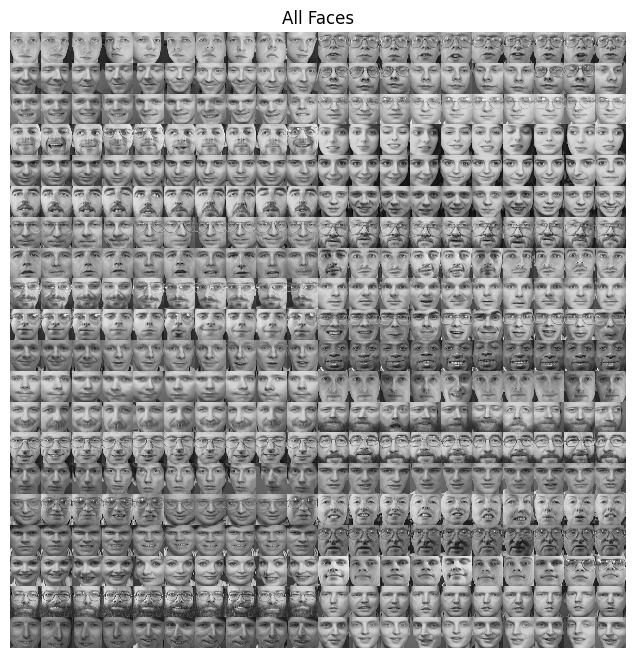

In [4]:
import matplotlib.pyplot as plt
from skimage import util

%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(8,8))
ax1.imshow(util.montage(X_vec[:,:,:,0]), cmap='gray', interpolation='none')

ax1.set_title('All Faces')
ax1.axis('off')

- 첫번째 채널(RED)의 모든 이미지를 gray로 변환하여 보여줌
- `montage`: 여러개의 이미지를 하나의 2D 배열로 조합하여 모자이크 형태의 이미지를 생성

## 2. Pipeline 생성하기
### 이미지를 1D 벡터로 flatten 해주고, Gradient Boosting 분류기를 사용

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

class PipeStep(object):
  def __init__(self, step_func):
    self._step_func=step_func
  def fit(self, *args):
    return self
  def transform(self, X):
    return self._step_func(X)

# 주어진 이미지 리스트에서 각 이미지를 회색조 이미지로 변환
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])

# 각 이미지를 1차원 배열로 변환, 이미지의 모든 픽셀을 단일 벡터로 flatten
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()), # 각 샘플의 픽셀 값을 정규화
    ('PCA', PCA(25)), # 데이터의 차원을 25개 주요 성분으로 축소
    ('XGBoost', GradientBoostingClassifier())
])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70, random_state=5)

In [7]:
simple_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7a4fd85b8b90>),
                ('Flatten Image', <__main__.PipeStep object at 0x7a4fd85bcb60>),
                ('Normalize', Normalizer()), ('PCA', PCA(n_components=25)),
                ('XGBoost', GradientBoostingClassifier())])

## 3. 모델 평가하기

In [9]:
# classification_report 출력

pred_test = simple_pipeline.predict(X_test) # 카테고리 분류 결과
pred_prop = simple_pipeline.predict_proba(X_test) # 각 카테고리 별 예측 확률 결과

from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=pred_test)) # 정밀도, 재현율, f1-score, support(각 카테고리 별 데이터 수)

              precision    recall  f1-score   support

           0       0.15      1.00      0.27         2
           1       0.75      1.00      0.86         3
           2       0.11      0.50      0.18         2
           3       0.12      1.00      0.22         1
           4       1.00      0.20      0.33         5
           5       0.80      0.80      0.80         5
           6       1.00      0.33      0.50         3
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.50      0.33      0.40         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         3
          14       0.25      0.33      0.29         3
          15       0.25      0.33      0.29         3
          16       0.20      1.00      0.33         1
          17       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- macro avg: 모든 카테고리의 f1-score를 단순 평균한 결과
- weighted avg: 모든 카테고리의 f1-score를 각 카테고리의 데이터 개수를 고려하여 가중 평균

In [10]:
# lime으로 설명체 구현
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer(verbose=False) # lime 이미지 설명체 생성
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1) # 이미지를 세그먼트(슈퍼픽셀)로 나누기 위한 알고리즘 설정
# slic: 이미지를 동질의 클러스터로 분할하는 방법(n_segments=100 => 100개의 세그먼트로 나누기)

### LIME 설명체 구성에 필요한 정보
1. 설명이 필요한 하나의 데이터 (로컬 대리 분석)
2. 해당 데이터에 대한 분류 확률을 출력하는 모델 (분류기 모델의 predict_proba)

In [13]:
test_index = 100
explanation = explainer.explain_instance(X_test[test_index],
                            classifier_fn = simple_pipeline.predict_proba,
                            top_labels = 6, # 모델이 예측한 1등부터 6등까지의 클래스 분석
                            num_samples = 1000, # 결정 경계를 결정하기 위해 주변에 탐색하는 포인트 수
                            segmentation_fn = segmenter)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Positive/Negative Regions for 2')

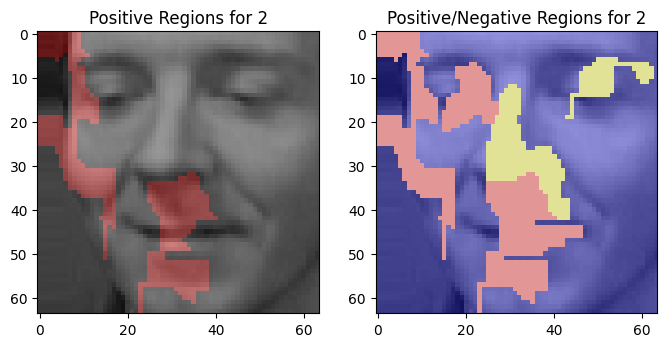

In [14]:
# 하나의 이미지에 대해 클래스 분류에 영향을 주는 부분을 표시
from skimage.color import label2rgb

# 주어진 레이블에 대한 이미지의 설명 추출(get_image_and_mask)
# positive_only=True: 긍정적인 기여도만 고려함
# num_features=5: 상위 5개의 특징을 고려
# hide_rest=False: 이미지의 나머지 부분을 보여줌
temp, mask = explanation.get_image_and_mask(y_test[test_index], positive_only=True, num_features=5, hide_rest=False)

# 2개의 그림 그리기
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))

# 첫 번째 이미지: 모델의 예측에 긍정적으로 기여한 영역만 보여줌
# label2rgb: 설명의 마스크를 RGB 이미지로 변환하여 긍정적인 영역을 색상으로 표시
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[test_index]))

# 두 번째 이미지: 모델에 긍정적, 부정적으로 기여한 영역을 모두 표시(positive_only=False)
temp, mask = explanation.get_image_and_mask(y_test[test_index],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)  # 주요 10개의 특징
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[test_index]))

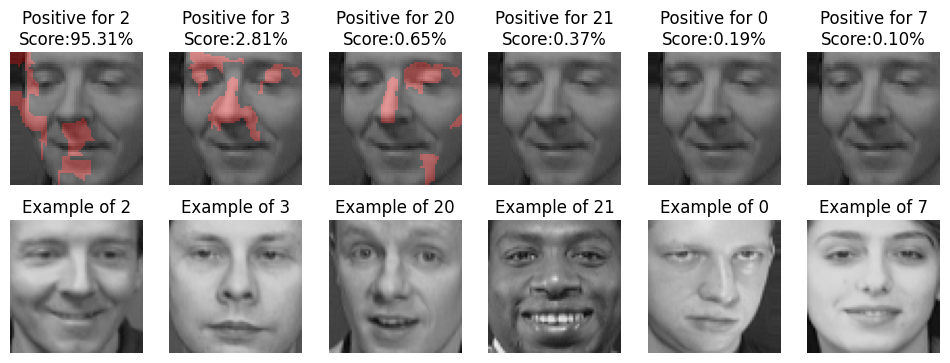

In [15]:
# 모델이 예측한 결과와 그에 대한 설명을 도시

# 2행 6열로 총 12개의 그래프 영역을 생성
fig, m_axs = plt.subplots(2,6, figsize = (12,4))

for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    # 특정 레이블 'i' 에 대해 이미지의 설명 반환
    temp, mask = explanation.get_image_and_mask(i,
                                                positive_only=True,   # 긍정적인 영향만 포함
                                                num_features=5,       # 주요한 5개의 특징
                                                hide_rest=False,
                                                min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pred_prop[test_index, i]))    # 모델의 해당 레이블 예측 확률을 표기
    c_ax.axis('off')

    # 학습 데이터의 레이블 i 에 해당하는 이미지를 무작위로 선택
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])                # 선택된 인덱스의 이미지를 표시
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

### 틀린 예측 사례를 분석

In [16]:
np.random.seed(15)      # 랜덤 시드 고정
wrong_idx = np.random.choice(np.where(pred_test!=y_test)[0])    # 예측값과 실제값이 일치하지 않는 케이스 중 하나를 무작위로 선택
# np.where: 해당 조건이 참인 경우의 인덱스를 배열로 반환
# np.random.choice: 해당 인덱스 배열에서 하나의 인덱스를 선택 - 모델이 잘못 예측한 샘플의 위치를 의미

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pred_test[wrong_idx]))
# 잘못된 예측의 인덱스: wrong_idx
# 실제 레이블: y_test[wrong_idx]
# 모델의 예측값 출력: pred_test[wrong_idx]

Using #20 where the label was 33 and the pipeline predicted 20


In [17]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_pipeline.predict_proba,
                                         top_labels=6, hide_color=0, num_samples=1000, segmentation_fn=segmenter)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 3.21 s, sys: 13.3 ms, total: 3.22 s
Wall time: 1.78 s


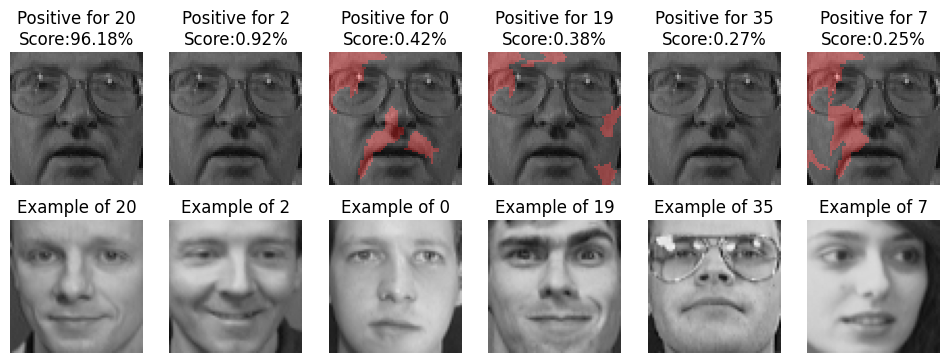

In [18]:
# 잘못 예측된 그림을 분석
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pred_prop[wrong_idx, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')